# Tuto\#3 Fit the histograms with a likelihood
In this tutorial, we are going to fit the histograms to get self-calibrated null depth.

**Important: the self-calibration is as good as the model**.

Once again, we load the data, get the histograms, prepare the model then we perform the fit.

## Load data and get the histogram

In [1]:
import h5py
import numpy as np
import os
from timeit import default_timer as time
from datetime import datetime
import matplotlib.pyplot as plt
import sys

datafolder = 'dataset/'
darkfolder = datafolder
save_path = 'results/'

In [2]:
import grip
try:
    import cupy as cp # To use the GPU to speed up the process
except ModuleNotFoundError:
    import numpy as cp # If no GPU, we load numpy again with the same acronym to still use the functions


wl_min, wl_max = 11000, 11200
dark_list = ['dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5']
data_list = ['dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5']
dark = grip.load_data(dark_list, ['wl_scale', 'Iminus1', 'p1', 'p2'], (wl_min, wl_max))
data = grip.load_data(data_list, ['wl_scale', 'Iminus1', 'p1', 'p2', 'intraphase_rms'], (wl_min, wl_max))

wl_scale = data['wl_scale']
dark_IA, dark_IB = dark['p1'], dark['p2']
dark_Iminus = dark['Iminus1']
Iminus = data['Iminus1']
data_IA, data_IB = data['p1'], data['p2']

# Calculate the null depth
Iplus = data_IA + data_IB + 2 * (data_IA * data_IB)**0.5 # Using the estimator above
data_null = Iminus / Iplus # Calculated null depth

# Get the histogram
bin_bounds = (-0.01, 0.1) # Minimum and maximum values of the bins of the histogram
normed=True # We want to normalise the histogram by its sum

null_axis, null_pdf, null_pdf_err, sz = grip.compute_data_histogram(data_null, \
                                                          bin_bounds, \
                                           wl_scale, normed=normed)

injection, spectra = grip.get_injection_and_spectrum(
    data_IA, data_IB, wl_scale, (wl_min, wl_max))
nb_frames_binning_photometry = -1 # Bin over all the sample
injection, dummy = grip.binning(
    injection, nb_frames_binning_photometry, axis=1, avg=True)


data_IA_axis = cp.linspace(injection[0].min(), injection[0].max(),
                           np.size(np.unique(injection[0])),
                           dtype=cp.float32)
cdf_data_IA = grip.computeCdf(data_IA_axis, injection[0], 'cdf', True)
cdf_data_IA = cp.array(cdf_data_IA, dtype=cp.float32)

data_IB_axis = cp.linspace(injection[1].min(), injection[1].max(),
                           np.size(np.unique(injection[1])),
                           dtype=cp.float32)
cdf_data_IB = grip.computeCdf(data_IB_axis, injection[1], 'cdf', True)
cdf_data_IB = cp.array(cdf_data_IB, dtype=cp.float32)

sigma_eps = data['intraphase_rms']
sigma_eps = np.radians(sigma_eps)
sigma_eps *= 2200 / wl_scale
sigma_eps = sigma_eps.reshape((1, -1))
sigma_eps_axis, sigma_eps_cdf = grip.get_dark_cdf(sigma_eps, wl_scale)

std_dark_Iminus = np.std(dark_Iminus)
dark_Iminus -= np.mean(dark_Iminus, 1, keepdims=True) # The model is better when the data are forced to be of average 0
    
dark_Iminus_axis, dark_Iminus_cdf = grip.get_dark_cdf(
    dark_Iminus, wl_scale)

rvu_opd = None # To generate RV reproducing the statistics of the OPD fluctuations
rvu_IA = None # To generate RV reproducing the statistics of the injection of beam A
rvu_IB = None # To generate RV reproducing the statistics of the injection of beam B
rvu_bg = [None]*wl_scale.size # To generate RV reproducing the statistics of the thermal background, per spectral channel
rvu_eps = [None]*wl_scale.size # To generate RV reproducing the statistics of the fringe blurring, per spectral channel

# Uncomment the lines below to play with "deterministic" Monte-Carlo
# rvu_opd = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_IA = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_IB = cp.random.uniform(0, 1, size=n_samp_per_loop, dtype=cp.float32)
# rvu_bg = cp.random.uniform(0, 1, size=(wl_scale.size, n_samp_per_loop), dtype=cp.float32)
# rvu_eps = cp.random.uniform(0, 1, size=(wl_scale.size, n_samp_per_loop), dtype=cp.float32)

# Embed all of the above in lists
rvus = [rvu_IA, rvu_IB, rvu_bg, rvu_eps]
cdfs = [(data_IA_axis, cdf_data_IA), (data_IB_axis, cdf_data_IB),\
        (dark_Iminus_axis, dark_Iminus_cdf), (sigma_eps_axis, sigma_eps_cdf)]


dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5
dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5


## Fit the histograms
Now, let's dive into the core of this tutorial.

We will use the negative binomial lilelihood as a cost function.
As a reminder, the number of elements in the bins follow a binomial distribution.
The code can be used in the same way with a $\chi^2$ cost function.

The null estimator is:
$ N = \frac{I_{-}}{I_{+}} $

$I_{-}(\lambda) =I_1(\lambda) + I_2(\lambda) + 2 \sqrt{I_1(\lambda) I_2(\lambda)} |V| \cos(\frac{2\pi}{\lambda} \Delta OPD) (1 - 0.5\sigma^2_\epsilon + 0.125 \sigma^2_\epsilon) + B(\lambda)$

$I_{+}(\lambda) = I_1(\lambda) + I_2(\lambda) + 2 \sqrt{I_1(\lambda) I_2(\lambda)}$

- $I_x$ is the intensity of the output
- $\Delta OPD$ is the phase of the fringe due to atmospheric turbulence, the phase is centered around $\pi$
- $\sigma_\epsilon$ is the standard deviation of the phase within an exposure time, thus doing fringe blurring
- $B$ is the thermal background

The LBTI does not record the bright fringe, the paper uses an ah hoc expression:

The parameters to explore are:
- the astrophysical null depth ($N_a = \frac{1-|V|}{1+|V|}$)
- the location $\mu$ and
- the scale $\sigma$ of the normal distribution describing the statistics of the fluctuations of phase $\Delta \phi$.

We first need to set the boundaries and the initial guesses.

In [3]:
bounds_mu = (0, 800) # Boundaries of mu opd
bounds_sig = (200, 400) # Boundaries of sig opd
bounds_na = (0.0, 0.01) # Boundaries of Na
mu_opd = 20. # initial guess of DeltaPhi mu
sig_opd = 340. # initial guess of DeltaPhi sig
na = 0.005 # initial guess of astro null

# Compile them into a readable tuple called by the TRF algorithm
bounds_fit = np.array(([bounds_na[0], bounds_mu[0], bounds_sig[0]],
              [bounds_na[1], bounds_mu[1], bounds_sig[1]])).T

initial_guess = [na, mu_opd, sig_opd]
initial_guess = np.array(initial_guess, dtype=np.float64)
spec_chan_width = 2600
instrument_constants = (spec_chan_width, np.pi)
n_samp_total = int(2e6)
n_samp_per_loop = int(1e6)
nloop = n_samp_total // n_samp_per_loop
diffstep_lklh = [0.05, 0.01, 0.01] # differential step


We are going to use `minimize_fit` to perform the model fitting.
It allows to choose the cost function.
It is powered by `scipy.optimize.minimize` with the L-BFGS-B algorithm.

If $\chi^2$ is preferred, GRIP has the function `lstsqrs_fit` powered by `scipy.optimize.curve_fit`.

Regardless the method, a critical parameter of the algorithm to tune is the **differential step**.
It is the typical step size to explore the parameter space and calculate the jacobian.
Baldy tune, the fit will perform poorly and the algorithm will likely converge to the initial guess, regardless how close to the true solutions they are.

In [4]:
cost_fun_args = (wl_scale, grip.lbti_model, instrument_constants, rvu_opd, cdfs, rvus)
cost_fun_kwargs = {'n_samp_per_loop':n_samp_per_loop, 'nloop':nloop, 'verbose':True}        
start = time()
popt, pcov, res = grip.minimize_fit(grip.neg_log_multinomial, grip.create_histogram_model, initial_guess, 
                                null_axis, null_pdf, yerr=None, bounds=bounds_fit, 
                                diff_step=diffstep_lklh, func_args=cost_fun_args, func_kwargs=cost_fun_kwargs)
stop = time()
print('Duration of fit', stop - start)


/mnt/96980F95980F72D3/grip/grip/fit_tools.py:94: RuntimeWarning: divide by zero encountered in log
  stirling = n * np.log(n) - n
/mnt/96980F95980F72D3/grip/grip/fit_tools.py:94: RuntimeWarning: invalid value encountered in multiply
  stirling = n * np.log(n) - n
/mnt/96980F95980F72D3/grip/grip/fit_tools.py:142: RuntimeWarning: divide by zero encountered in log
  logmodel = np.log(model)


(1, 0.005, 20.0, 340.0)
(2, 0.00475, 20.0, 340.0)
(3, 0.00525, 20.0, 340.0)
(4, 0.005, 19.8, 340.0)
(5, 0.005, 20.2, 340.0)
(6, 0.005, 20.0, 336.6)
(7, 0.005, 20.0, 343.4)
(8, 0.01, 20.00095994127925, 340.0003778243204)
(9, 0.0095, 20.00095994127925, 340.0003778243204)
(10, 0.009000000000000001, 20.00095994127925, 340.0003778243204)
(11, 0.01, 19.800950341866457, 340.0003778243204)
(12, 0.01, 20.20096954069204, 340.0003778243204)
(13, 0.01, 20.00095994127925, 336.6003740460772)
(14, 0.01, 20.00095994127925, 343.40038160256364)
(15, 0.007153597869431755, 20.000413465498752, 340.0001627363303)
(16, 0.006795917975960167, 20.000413465498752, 340.0001627363303)
(17, 0.007511277762903343, 20.000413465498752, 340.0001627363303)
(18, 0.007153597869431755, 19.800409330843763, 340.0001627363303)
(19, 0.007153597869431755, 20.20041760015374, 340.0001627363303)
(20, 0.007153597869431755, 20.000413465498752, 336.60016110896703)
(21, 0.007153597869431755, 20.000413465498752, 343.4001643636936)
(22, 

After the fit, let's display the plots as explained in Tuto \#1.

(120, 0.0071608519991874595, 20.000415006367284, 340.0001632991984)


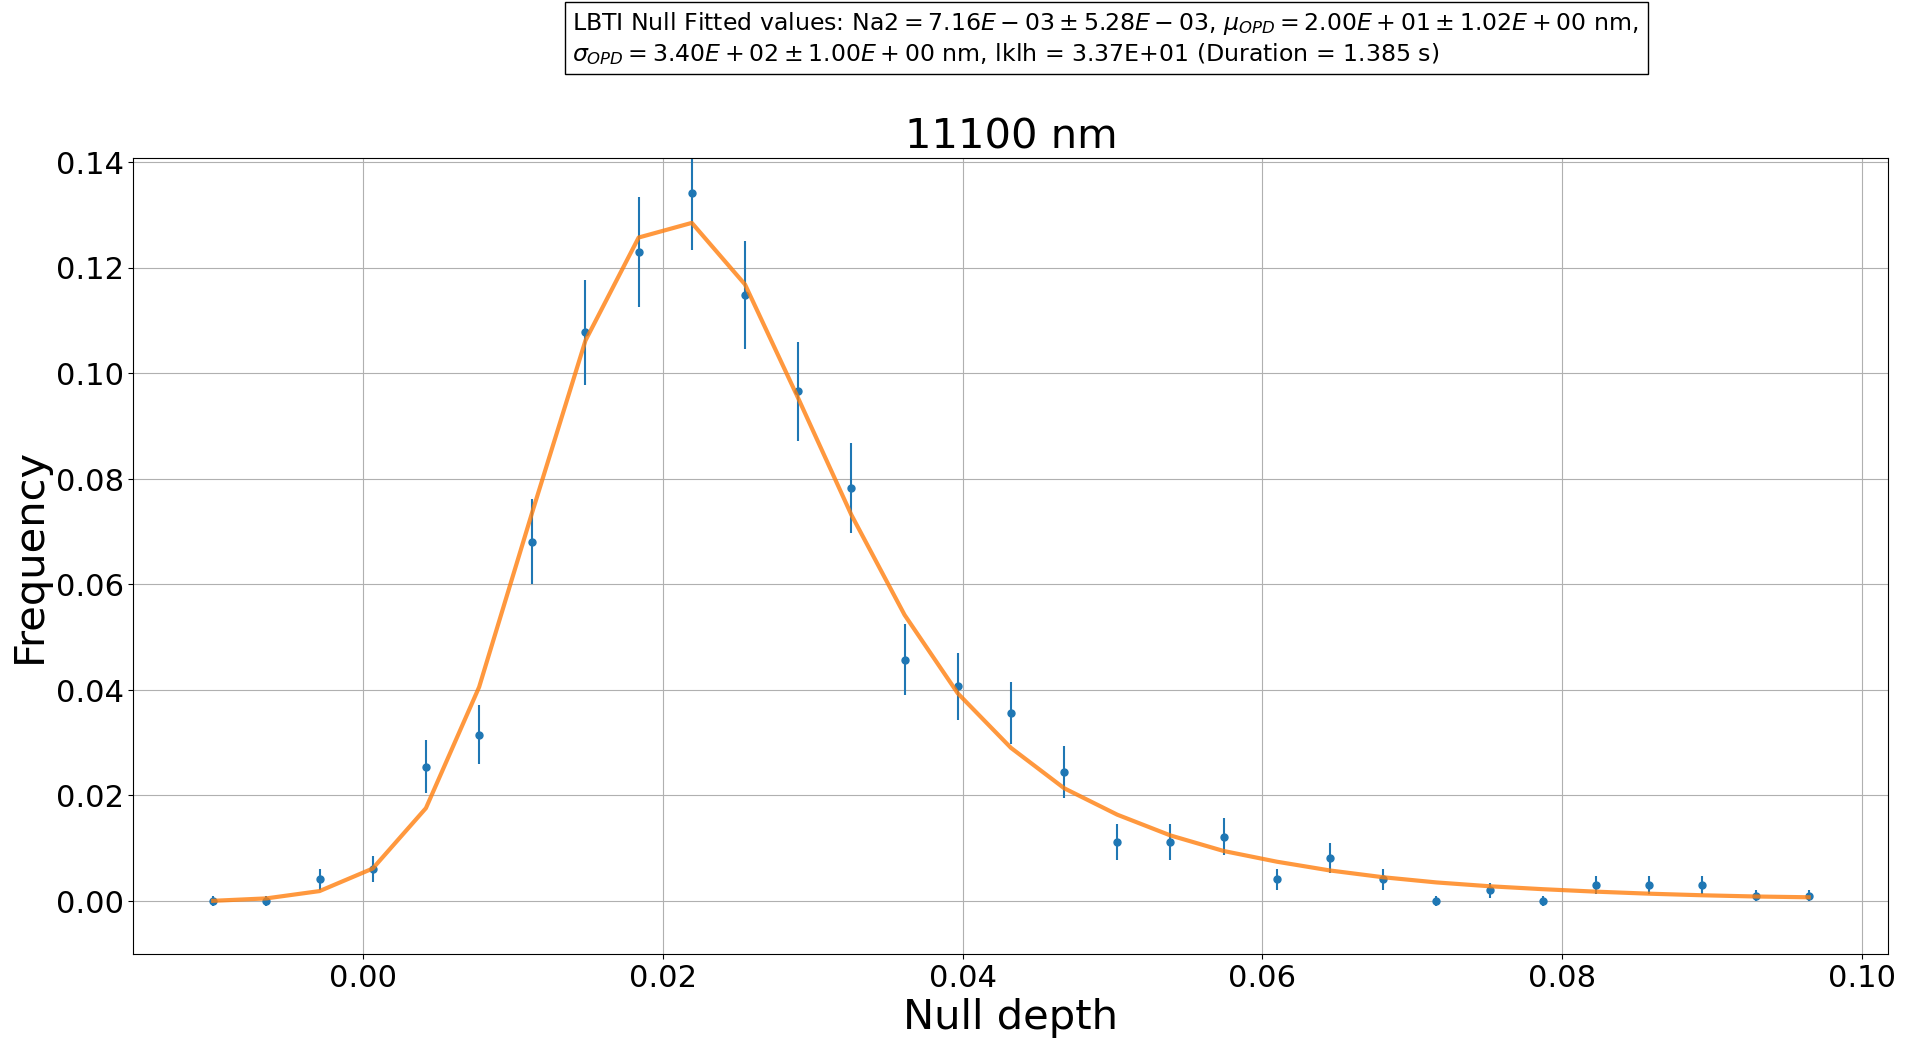

In [5]:
uncertainties = np.diag(pcov)**0.5
na_opt = popt[0]
out = grip.create_histogram_model(popt, null_axis, wl_scale, grip.lbti_model, instrument_constants, rvu_opd, cdfs, rvus, n_samp_per_loop=n_samp_per_loop, nloop=nloop)[0]

key = 'LBTI Null'
basin_hopping_count = 0

nb_rows_plot = 3
label_optimizer = 'lklh'
text_params = '%s ' % key+'Fitted values: ' +\
    'Na2$ = %.2E \pm %.2E$, ' % (na_opt,
                                uncertainties[0]) +\
    r'$\mu_{OPD} = %.2E \pm %.2E$ nm, ' % (popt[1],
                                            uncertainties[1]) +\
    '\n' + r'$\sigma_{OPD} = %.2E \pm %.2E$ nm,' % (
        popt[2], uncertainties[2]) +\
    ' '+label_optimizer+' = %.2E ' % (res.fun) +\
    '(Duration = %.3f s)' % (stop-start)
    
save_name = key + '_' + '%03d' % (basin_hopping_count) + '_' + str(wl_min) + '-' + str(wl_max) + '_' + os.path.basename(datafolder[:-1])
grip.plot_null_distributions(nb_rows_plot, wl_scale, text_params, null_axis, null_pdf,\
                            null_pdf_err, save_path, save_name, model=out,\
                                save_fig=True)

Now we have apparently a good fit.
We can explore the quality of the fit with the diagnostic tools.

(121, 0.0071608519991874595, 20.000415006367284, 340.0001632991984)


/home/mam/miniconda3/envs/env_instru/lib/python3.11/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


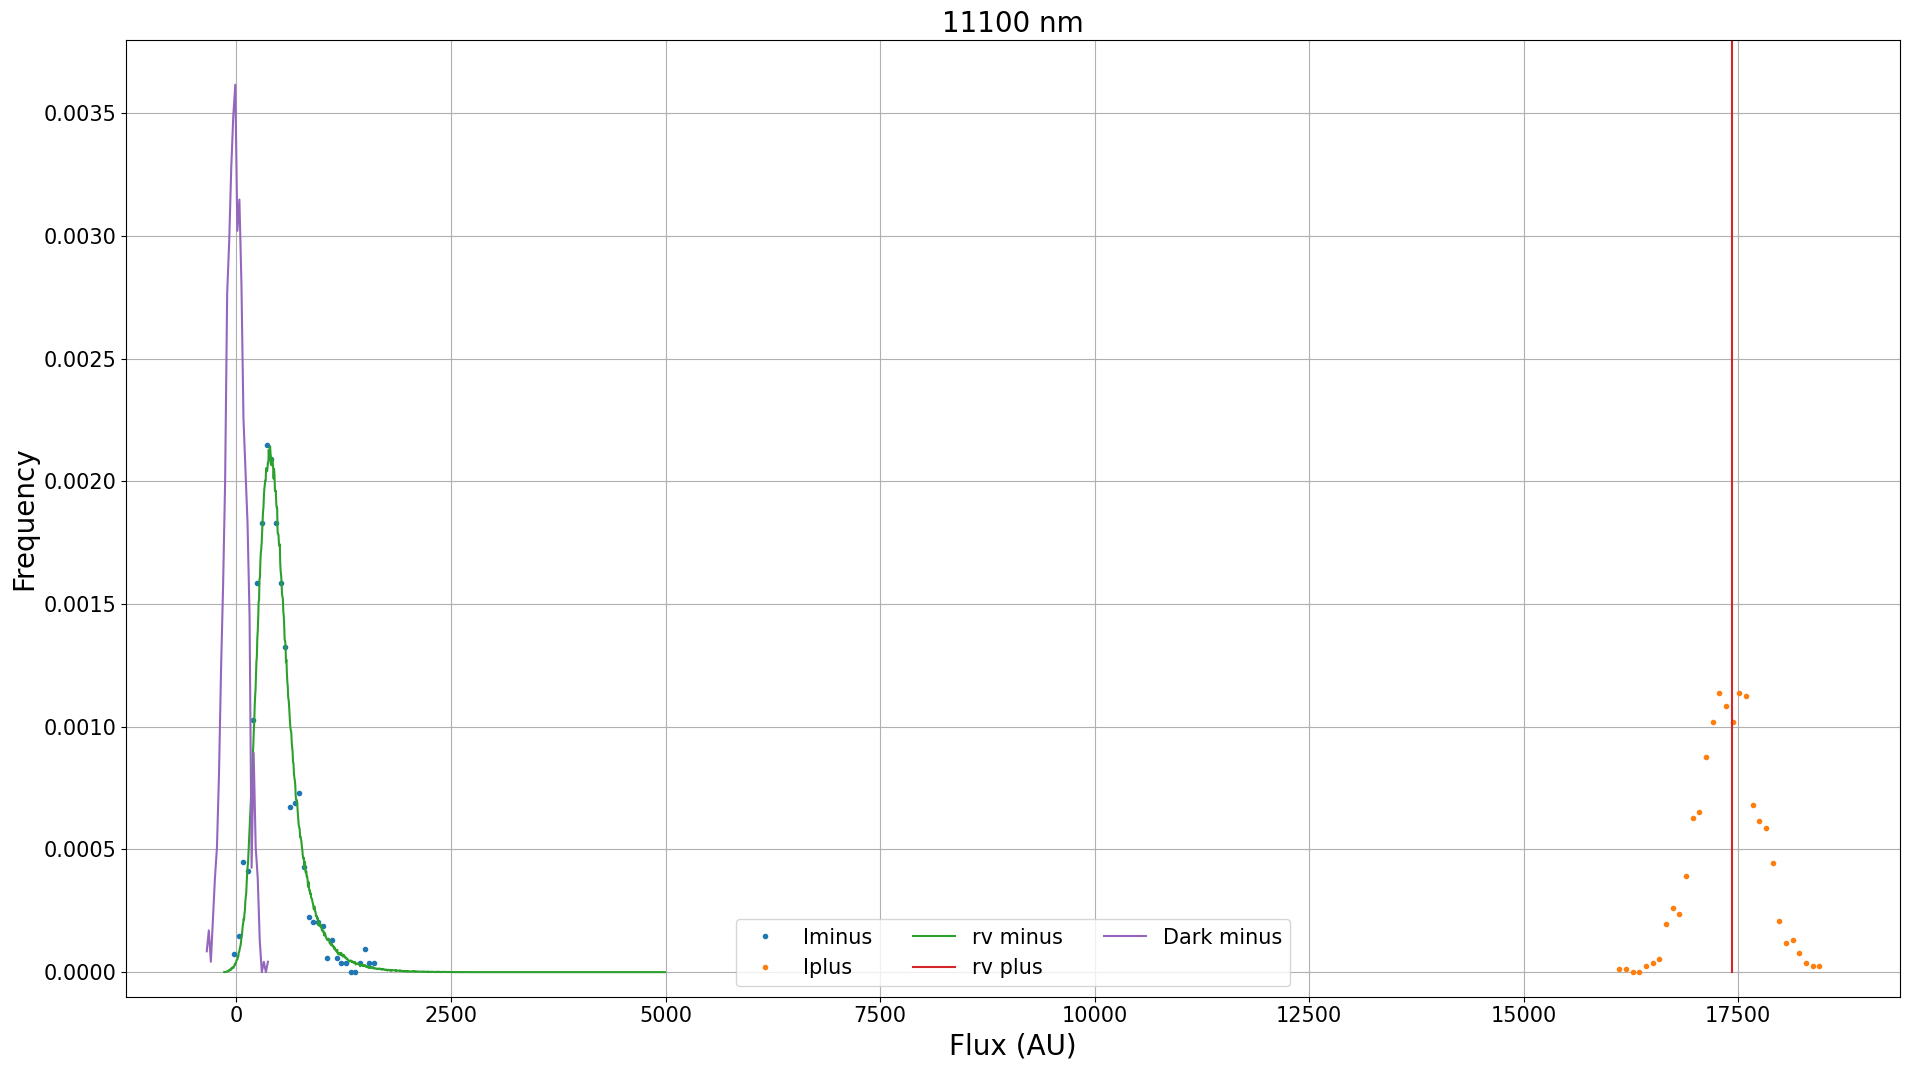

In [6]:
out = grip.create_histogram_model(popt, null_axis, wl_scale, grip.lbti_model, instrument_constants, rvu_opd, cdfs, rvus, n_samp_per_loop=n_samp_per_loop, nloop=nloop)
synth_histo = out[0] # Flatten histogram along the wavelength axis.
diag = out[1][0]
diag = cp.array(diag)
diag = cp.asnumpy(diag)
diag_opd = cp.asnumpy(cp.array(out[2][0][0][0]))
diag_IA = cp.asnumpy(cp.array(out[2][0][0][1]))
diag_IB = cp.asnumpy(cp.array(out[2][0][0][2]))
diag_dkIA = cp.asnumpy(cp.array(out[3])[0,:,0])
diag_dkIB = cp.asnumpy(cp.array(out[3])[0,:,1])

liste_rv_interfminus = diag[:,0,:]
liste_rv_interfplus = diag[:,1,:]

histom = [np.histogram(Iminus[k], bins=int(
    Iminus[k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histom = [(elt[0][:-1], elt[1]) for elt in histom]

histom2 = [np.histogram(liste_rv_interfminus[k], bins=int(
    liste_rv_interfminus[k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histom2 = [(elt[0][:-1], elt[1]) for elt in histom2]

histop = [np.histogram(Iplus[k], bins=int(
    Iplus[k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histop = [(elt[0][:-1], elt[1]) for elt in histop]

histop2 = [np.histogram(liste_rv_interfplus[k], bins=int(
    liste_rv_interfplus[k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histop2 = [(elt[0][:-1], elt[1]) for elt in histop2]

histodkm = [np.histogram(dark['Iminus1'][k], bins=int(
    dark['Iminus1'][k].size**0.5), density=True)[::-1]
    for k in range(wl_scale.size)]
histodkm = [(elt[0][:-1], elt[1]) for elt in histodkm]

# Diagnostic on the synthetic sequence of nulled and anti-nulled signal
markers = ['.', '-', '-']
data_xy = ((histom, histop), (histom2, histop2), (histodkm,))
labels = (('Iminus', 'Iplus'), ('rv minus', 'rv plus'), ('Dark minus',))
save_name = key +\
    '_details_' + str(wl_min) + '-' + str(wl_max) + '_' +\
    os.path.basename(datafolder[:-1])
grip.plot_diag_spectral_data(nb_rows_plot, wl_scale, data_xy, labels, save_path, \
                    save_name, markers, save_fig=True)



Apparently, it is all good, the results look reliable.

But we are hitting some limitations of GRIP we need to test:
- the Monte-Carlo is a random process. The parameter space always changes a bit, so a picky scientist may think the result is just luck
- the differential step looks well-tuned, not all parameters loop back to their initial guesses

A way to address these is to repeat the fit with different initial guesses.
This technique is known as Basin hopping and is a way to find the global minimum of the cost function with an algorithm designed to find the local minima.

**Bonus**: In order to keep track of everything done, GRIP has a Logger (`grip.Logger`) to save the content of the terminal. However, it does not work in a Jupyter notebook so it is not used here.

-------------
0
-------------
Fitting LBTI Null
2024-01-24 15h38
Spectral bandwidth (in nm):11000,11200
Time binning of photometry: -1
Bin bounds and number of bins (-0.01, 0.1) 5
Boundaries (na, mu, sig):
(0.0, 0.01)(0, 800)(200, 400)
Number of elements  2000000
Number of loaded points 984 1
Number of loaded dark points 990 1
Injection - shape array (2, 1)
Normed PDF True

(1, 0.0063, 20.0, 340.0)
(2, 0.004725, 20.0, 340.0)
(3, 0.007875, 20.0, 340.0)
(4, 0.0063, 14.0, 340.0)
(5, 0.0063, 26.0, 340.0)
(6, 0.0063, 20.0, 270.0)
(7, 0.0063, 20.0, 200.0)
(8, 0.01, 20.00000712663162, 339.9996339798729)
(9, 0.0075, 20.00000712663162, 339.9996339798729)
(10, 0.005, 20.00000712663162, 339.9996339798729)
(11, 0.01, 14.000004988642132, 339.9996339798729)
(12, 0.01, 26.000009264621106, 339.9996339798729)
(13, 0.01, 20.00000712663162, 269.99981698993645)
(14, 0.01, 20.00000712663162, 200.0)
(15, 0.00714916598034586, 20.000001635592735, 339.9999159968)
(16, 0.005361874485259395, 20.000001635592735, 

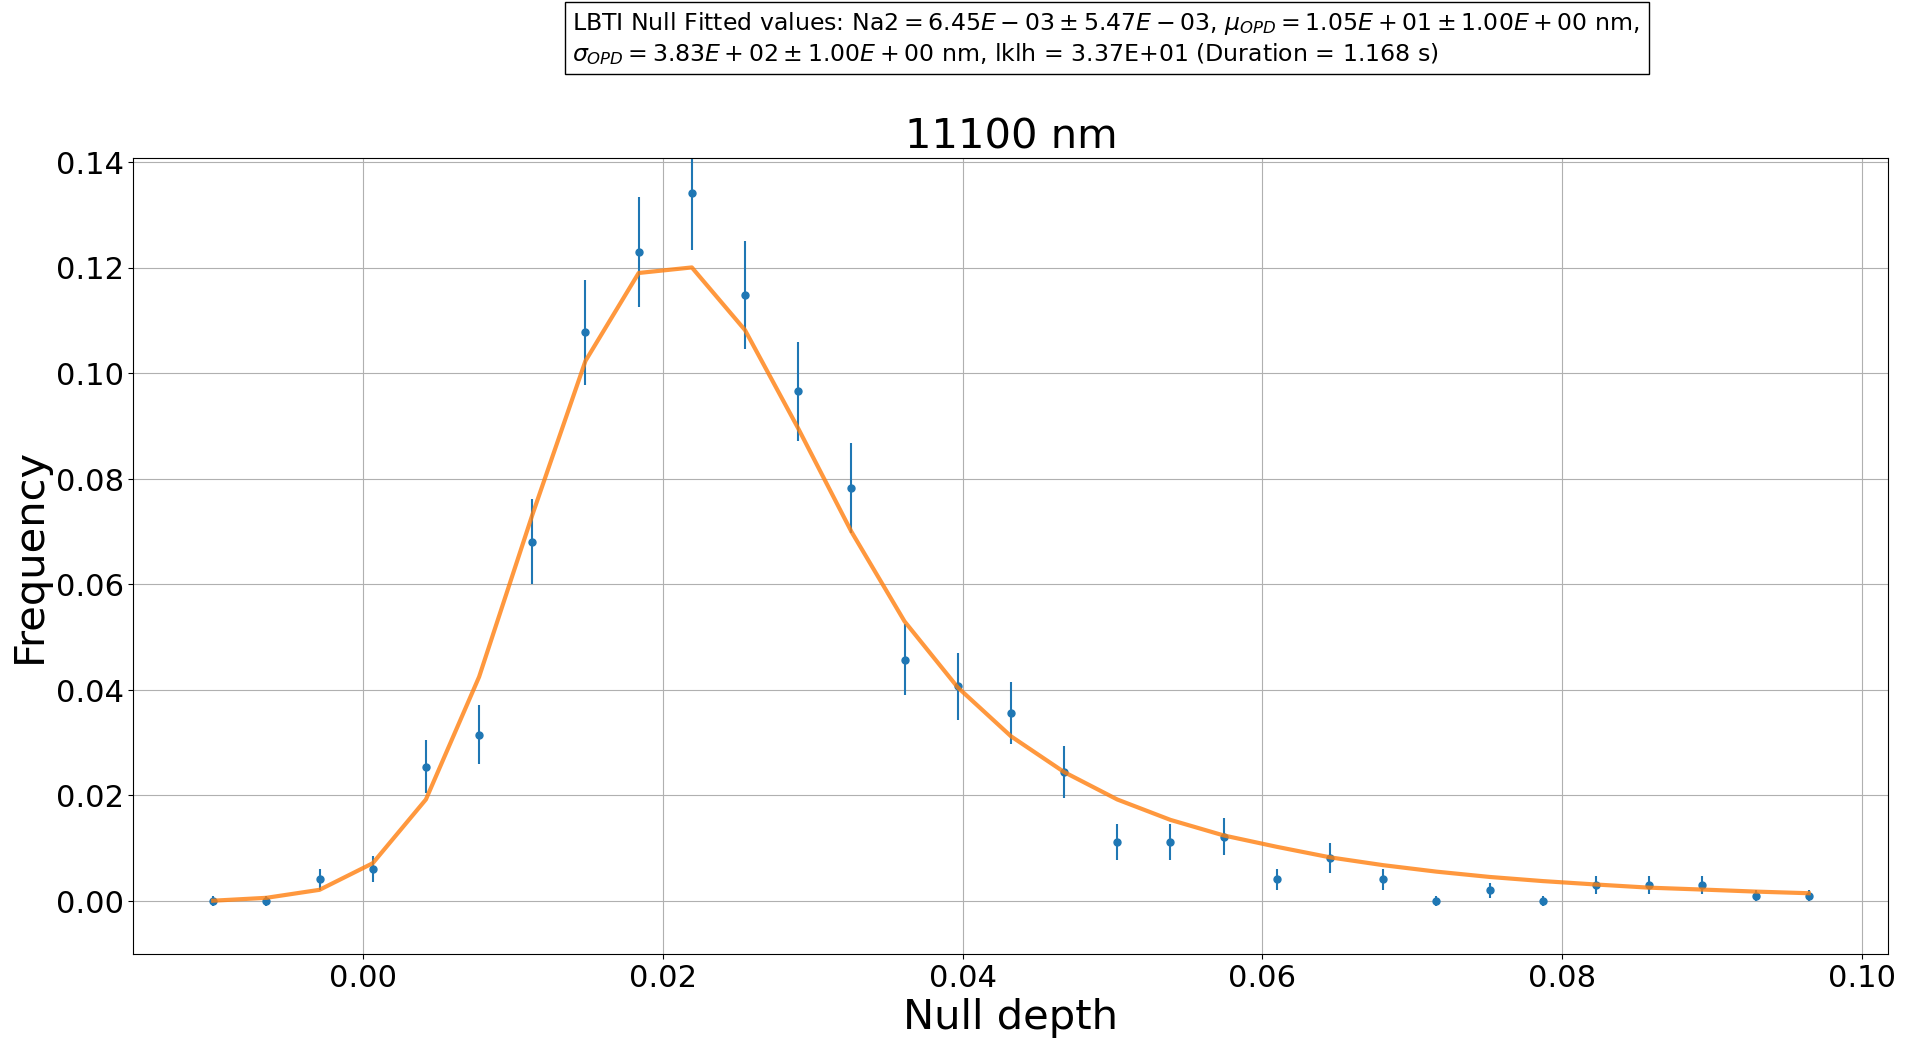

In [5]:
bounds_mu = (0, 800) # Boundaries of mu opd
bounds_sig = (200, 400) # Boundaries of sig opd
bounds_na = (0.0, 0.01) # Boundaries of Na
# Compile them into a readable tuple called by the TRF algorithm
bounds_fit = np.array(([bounds_na[0], bounds_mu[0], bounds_sig[0]],
              [bounds_na[1], bounds_mu[1], bounds_sig[1]])).T

mu_opd0 = 20 # initial guess of DeltaPhi mu
sig_opd0 = 340 # initial guess of DeltaPhi sig
na0 = 0.0063 # initial guess of astro null
key = 'LBTI Null'

spec_chan_width = 2600
instrument_constants = (spec_chan_width, np.pi)
n_samp_total = int(2e6)
n_samp_per_loop = int(1e6)
nloop = n_samp_total // n_samp_per_loop
diffstep_lklh = [0.05, 0.01, 0.01] # differential step
diffstep_lklh = [0.25, 0.3, 0.3]
nb_files_data = len(data_list)
nb_files_dark = len(dark_list)


k = 0
basin_hopping_nloop = (10*k, 10*k+10) # Let's do the fit 10 times
for idx_basin, basin_hopping_count in enumerate(
        range(basin_hopping_nloop[0], basin_hopping_nloop[1])):
    plt.close('all')
    grip.create_histogram_model.count = 0

    # Save the content written in the console into a txt file

    print('-------------')
    print(basin_hopping_count)
    print('-------------')
    print('Fitting '+key)
    print('%s-%02d-%02d %02dh%02d' % (datetime.now().year,
                                      datetime.now().month,
                                      datetime.now().day,
                                      datetime.now().hour,
                                      datetime.now().minute))
    print('Spectral bandwidth (in nm):%s,%s' % (wl_min, wl_max))
    print('Time binning of photometry: %s' % (
        nb_frames_binning_photometry))
    print('Bin bounds and number of bins %s %s' %
          (bin_bounds, int(sz**0.5)))
    print('Boundaries (na, mu, sig):')
    print(str(bounds_na)+str(bounds_mu)+str(bounds_sig))
    print('Number of elements ', n_samp_total)
    print('Number of loaded points', data_null.shape[1], nb_files_data)
    print('Number of loaded dark points',
          dark['Iminus1'].shape[1], nb_files_dark)
    print('Injection - shape array', injection.shape)
    print('Normed PDF', normed)
    print('')

    """
    Prepare initial guess
    """
    # Create the set of initial guess for each hop
    if idx_basin > 0:
        mu_opd, sig_opd, na = grip.basin_hoppin_values(
            mu_opd0, sig_opd0, na0,
            bounds_mu, bounds_sig, bounds_na)
    else:
        mu_opd = mu_opd0
        sig_opd = sig_opd0
        na = na0

    initial_guess = [na, mu_opd, sig_opd]
    initial_guess = np.array(initial_guess, dtype=np.float64)
    cost_fun_args = (wl_scale, grip.lbti_model, instrument_constants, rvu_opd, cdfs, rvus)
    cost_fun_kwargs = {'n_samp_per_loop':n_samp_per_loop, 'nloop':nloop, 'verbose':True}        
    start = time()
    popt, pcov, res = grip.minimize_fit(grip.neg_log_multinomial, grip.create_histogram_model, initial_guess, 
                                    null_axis, null_pdf, yerr=None, bounds=bounds_fit, 
                                    diff_step=diffstep_lklh, func_args=cost_fun_args, func_kwargs=cost_fun_kwargs)
    stop = time()
    print('Duration of fit', stop - start)
    uncertainties = np.diag(pcov)**0.5
    na_opt = popt[0]
    out = grip.create_histogram_model(popt, null_axis, wl_scale, grip.lbti_model, instrument_constants, rvu_opd, cdfs, rvus, n_samp_per_loop=n_samp_per_loop, nloop=nloop)[0]
    
    nb_rows_plot = 3
    label_optimizer = 'lklh'
    text_params = '%s ' % key+'Fitted values: ' +\
        'Na2$ = %.2E \pm %.2E$, ' % (na_opt,
                                    uncertainties[0]) +\
        r'$\mu_{OPD} = %.2E \pm %.2E$ nm, ' % (popt[1],
                                                uncertainties[1]) +\
        '\n' + r'$\sigma_{OPD} = %.2E \pm %.2E$ nm,' % (
            popt[2], uncertainties[2]) +\
        ' '+label_optimizer+' = %.2E ' % (res.fun) +\
        '(Duration = %.3f s)' % (stop-start)
        
    save_name = key + '_' + '%03d' % (basin_hopping_count) + '_' + str(wl_min) + '-' + str(wl_max) + '_' + os.path.basename(datafolder[:-1])
    grip.plot_null_distributions(nb_rows_plot, wl_scale, text_params, null_axis, null_pdf,\
                                null_pdf_err, save_path, save_name, model=out,\
                                    save_fig=True)

We need to save the fitted parameters at each iteration and select the one which has the smallest value of the cost function.
This is beyond the scope of this tutorial.

The result is the self-calibrated null depth.
However, if the model does not handle some effects, the use of a calibrator is necessary.
Its data will go exactly through the same process (pre-processing + GRIP) and classic bias correction applies.

On this dataset, the null depth given by GRIP needs a classical calibration, as per Defrère+ (2016) because GRIP implements the exact same model as exposed in this article.

## Congratulations, we know the core of GRIP: the self-calibration.

## Going beyond this tutorial
We can use a $\chi^2$ cost function to find the self-calibrated null depth.
The function to use is `lstsqrs_fit`, it has the same interface as `minimize_fit`.
Everything is the same but:
- use the error bars on the PDF
- change the differential step, recommended values are `[0.005, 10, 10]`